# HW2: Differential Privacy Foundations

### Bhaven Patel
### 3/12/2019

I worked with Anthony Rentsch and Lipika Ramaswamy on this homework.

## Problem 1: Mechanisms

## Problem 2: Evaluating DP Algorithms with Synthetic Data

In [1]:
rm(list=ls())		# Remove any objects in memory

**(a)**<br>
Create a data generating function that samples from the Poisson distribution.

In [2]:
# Random draws from Poisson distribution
#
# mean- numeric, mean of the distribution
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# sample_poisson(num_draws=1000)

sample_poisson <- function(mean=10, num_draws=1){
	data = rpois(n = num_draws, lambda = mean);
    return(data);
}

**(b)**<br>
I picked the first mechanism from Problem 1: $M(x) = [\bar{x} + Z]_0^1$, $Z \sim Lap \left(\dfrac{GS}{\epsilon} \right)$

In [3]:
# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))
# Taken from James Honaker's histogramRelease.r
sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)
# Taken from James Honaker's histogramRelease.r
rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

## Clip a variable to a range. Taken from James Honaker's histogramRelease.r
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)
}

## Differentially private mean release. Taken from James Honaker's laplaceMeanReleaseFull.r
meanRelease <- function(x, lower=0, upper, epsilon){
    n <- length(x); #get number of data points/observations
    
    sensitivity <- (upper - lower)/n; #calculate GS
    scale <- sensitivity / epsilon; #calculate scale for laplace noise

    x.clipped <- clip(x, lower, upper);
    sensitiveValue <- mean(x.clipped);
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1);
    DPrelease <- clip(DPrelease, lower, upper); #clip the DP-mean if it lower/greater than the desired bounds
    
    return(list(release=DPrelease, true_clipped=sensitiveValue ));
}

**(c)**<br>
For n=200 and $\epsilon$=0.5, plot the root mean squared error as a function of the upper bound b

In [4]:
#set parameters
n = 200;
epsilon = 0.5;
num_sims = 10; #number of simulations to run for each upper bound

In [5]:
#set the seed
set.seed(24);

b_vals = seq(from = 1, to=100); #create sequence of upper bounds

datasets <- matrix(NA, nrow=n, ncol=num_sims);
#generate 'num_sims' different datasets from Poisson distribution
for(i in 1:num_sims){
    datasets[,i] = sample_poisson(num_draws = n); #put i-th dataset in column i
}
dataset_means = colMeans(datasets); #calculate mean for each dataset

#create matrix to hold upper bound and rmse for mean DP-releases, average mean
rmse_vals = matrix(NA, nrow=length(b_vals), ncol=3); 
for(b in b_vals){
    dp_means = c(); #vector to hold DP-released means for each simulation
    for(i in 1:num_sims){
        results = meanRelease(datasets[,i], lower = 0, upper = b, epsilon = epsilon); #get mean release
        dp_means <- c(dp_means, results$release);
    }
    
    #calculate RMSE
    rmse = ( sum( (dp_means - dataset_means)**2 ) / length(dp_means)) ** 0.5; 
    rmse_vals[b,] <- c(b, rmse, mean(dp_means));
}


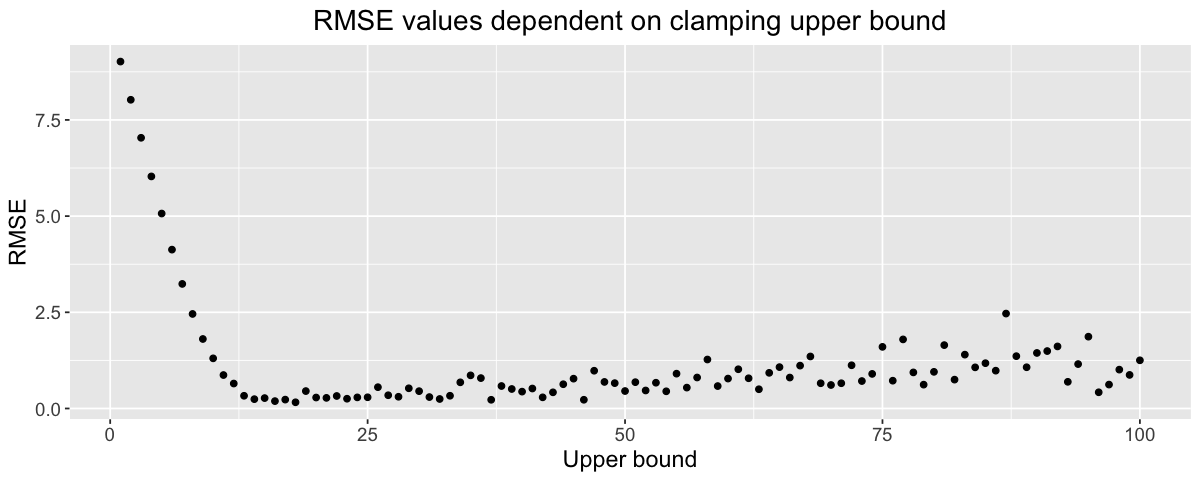

In [6]:
library(ggplot2); #import library for plotting
library(grid);

#### Plot results ####
final_results <- as.data.frame(rmse_vals);
colnames(final_results) <- c("Upper_bound", "RMSE", "Average true mean");
f_size = 16;
fifty = 0.5;
# Plot average RMSE of reconstruction against noise input
p_rmse <- ggplot(data = final_results, aes(x=final_results$Upper_bound, y=final_results$RMSE)) + geom_point();
p_rmse <- p_rmse + labs(title="RMSE values dependent on clamping upper bound", x="Upper bound", y = "RMSE") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));
options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p_rmse #show plot

In [7]:
print(final_results[final_results$RMSE == min(final_results$RMSE), ]);

   Upper_bound     RMSE Average true mean
18          18 0.161492          9.954823


The optimal value $b^{*}$ is 18. From the graph, it looks like values from 16 to 18 all have comparable RMSE values and could be used as good upper bounds.

**(d)**<br>
If we generate an optimal value $b^*$ based on bootstrapped samples from our dataset $x$, then we may leak information about outliers in the our dataset. This would occur because some of the bootstraps will contain the outliers, and their RMSE's will be minimized when the upper bound for clipping is near or greater than the value of the outlier. Thus by looking at the graph of average RMSE versus upper bound for the bootstrapped samples, it is possible to infer what the values of the outliers could be. This would not be differentially private because outliers in the dataset could be identified.

**(e)**<br>
## finish

## Problem 3: Regression

**(a)**<br>

To produce a differentially-private release of $\hat\alpha$, I will create differentially private releases of the covariance of $x$ and $y$ ($S_{xy}$), the variance of $x$ ($S_{xx}$), the mean of $y$ ($\bar{y}$), and the mean of $x$ ($\bar{x}$). If our privacy budget is $\epsilon$, each of these releases will take a fraction of the privacy budget equal to $\dfrac{\epsilon}{4}$, and due to the composition rule, the total privacy loss will be at most $\epsilon$.<br>
$\hat\beta$ and $\hat\alpha$ can be calculated from the differentially private releases of $S_{xy}$, $S_{xx}$, $\bar{y}$, and $\bar{x}$ as follows:
$$
\hat\beta = \dfrac{S_{xy}}{S_{xx}}\\
\hat\alpha = \bar{y} - \hat\beta \bar{x}\\
$$
<br><br>
Below is my augmentation to the regression release code so that I also give a differentially private release of $\hat\alpha$.

In [4]:
## Differentially private regression slope release. Modified from laplaceRegressionRelease.r by James Honaker.
regressionRelease <- function(y, x, ylower, yupper, xlower, xupper, epsilon_parts){
	x.clipped <- clip(x, xlower, xupper)
	y.clipped <- clip(y, ylower, yupper)

	n <- length(x)
	sens.Sxy <- ((xupper-xlower)*(yupper-ylower))  
	sens.Sxx  <- ((xupper-xlower)^2)  

	scale.Sxy <- sens.Sxy / (epsilon_parts$Sxy);
	scale.Sxx <- sens.Sxx / (epsilon_parts$Sxx);

	sensitiveValue <- sum((x.clipped - mean(x.clipped))*(y.clipped - mean(y.clipped))) / sum((x.clipped -
                                                                                              mean(x.clipped))^2); 

    #get DP-releases of Sxy and Sxx to calculate beta-hat
    release.Sxy <- sum((x.clipped - mean(x.clipped))*(y.clipped - mean(y.clipped)))  + rlap(mu=0, b=scale.Sxy, size=1); 
	release.Sxx <- sum((x.clipped - mean(x.clipped))^2)              + rlap(mu=0, b=scale.Sxx, size=1);
    #get DP-releases of x-bar and y-bar to calculate alpha-hat
    release.xbar <- meanRelease(x, lower = xlower, upper = xupper, epsilon = epsilon_parts$xbar)$release;
    release.ybar <- meanRelease(y, lower = ylower, upper = yupper, epsilon = epsilon_parts$ybar)$release;
    
    #calculate beta-hat and alpha-hat
	postprocess.beta <- release.Sxy/release.Sxx;
    postprocess.alpha <- release.ybar - postprocess.beta * release.xbar;
    
    true.alpha = mean(y.clipped) - sensitiveValue * mean(x.clipped); #calculate the true alpha of the clipped values
	return(list(dp_beta=postprocess.beta, true_beta=sensitiveValue, dp_alpha=postprocess.alpha,
                true_alpha=true.alpha))
}

First, I want to find a good upper bound for clamping the y's.

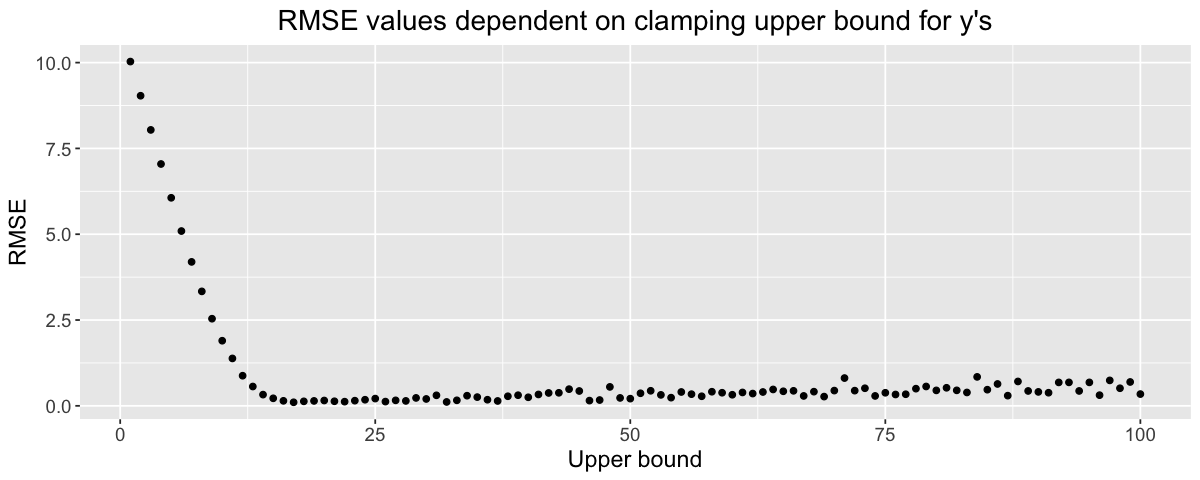

In [9]:
#set the seed
set.seed(24);

n = 200;
num_sims = 10; #number of simulations to run for each upper bound
alpha = beta = sigma = epsilon = 1;

b_vals = seq(from = 1, to=100); #create sequence of upper bounds

datasets <- matrix(NA, nrow=n, ncol=num_sims);
#generate 'num_sims' different datasets from Poisson distribution
for(i in 1:num_sims){
    x_data = sample_poisson(num_draws = n); 
    datasets[,i] = alpha*x_data + beta + rnorm(n=n, mean=0, sd=sigma); #put i-th dataset in column i
}
dataset_means = colMeans(datasets); #calculate mean for each dataset

#create matrix to hold upper bound and rmse for mean DP-releases, average mean
rmse_vals = matrix(NA, nrow=length(b_vals), ncol=3); 
for(b in b_vals){
    dp_means = c(); #vector to hold DP-released means for each simulation
    for(i in 1:num_sims){
        results = meanRelease(datasets[,i], lower = 0, upper = b, epsilon = epsilon); #get mean release
        dp_means <- c(dp_means, results$release);
    }
    
    #calculate RMSE
    rmse = ( sum( (dp_means - dataset_means)**2 ) / length(dp_means)) ** 0.5; 
    rmse_vals[b,] <- c(b, rmse, mean(dp_means));
}

#### Plot results ####
library(ggplot2)
final_results <- as.data.frame(rmse_vals);
colnames(final_results) <- c("Upper_bound", "RMSE", "Average true mean");
f_size = 16;
fifty = 0.5;
# Plot average RMSE of reconstruction against noise input
p_rmse <- ggplot(data = final_results, aes(x=final_results$Upper_bound, y=final_results$RMSE)) + geom_point();
p_rmse <- p_rmse + labs(title="RMSE values dependent on clamping upper bound for y's", x="Upper bound", y = "RMSE") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));
options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p_rmse #show plot

In [10]:
print(final_results[final_results$RMSE == min(final_results$RMSE), ]);

   Upper_bound      RMSE Average true mean
17          17 0.1037066          10.96932


I will use an upper bound of 18 for $x$ and an upper bound of 17 for $y$.

**(b)**<br>

In [5]:
#set the seed
set.seed(24);

#set parameters
y_lower = 0;
y_upper = 17;
x_lower = 0;
x_upper = 18;


n = 1000; #size of the dataset
num_sims = 1000; #number of Monte Carlo simulations to run
alpha = beta = sigma = epsilon = 1;

#define partitions for epsilon, which should all be epsilon/4
epsilon_parts = list(Sxy=epsilon/4, Sxx=epsilon/4, xbar=epsilon/4, ybar=epsilon/4);

#create matrix to hold upper bound and rmse for mean DP-releases, average mean
rmse_vals = matrix(NA, nrow=num_sims, ncol=3); 
for(i in 1:num_sims){
    #generate x-data and y-data
    x_data = sample_poisson(num_draws = n); 
    y_data = alpha*x_data + beta + rnorm(n=n, mean=0, sd=sigma);
    #get regression release beta and alpha
    reg_release <- regressionRelease(y_data, x_data, ylower=y_lower, yupper=y_upper, 
                                     xlower=x_lower, xupper=x_upper, epsilon_parts=epsilon_parts);

    #calculate y for each x point in dataset using regression release statistics
    y_dp <- reg_release$dp_beta * x_data + reg_release$dp_alpha;
    y_nondp <- reg_release$true_beta * x_data + reg_release$true_alpha; #calc y using non-dp stats
    #calculate RMSE for the DP release stats
    rmse_dp = ( sum( (y_dp - y_data)**2 ) / length(y_data)) ** 0.5;
    #calculate RMSE for the non-DP release stats
    rmse_nondp = ( sum( (y_nondp - y_data)**2 ) / length(y_data)) ** 0.5; 

    rmse_vals[i,] <- c(i, rmse_dp, rmse_nondp); #put RMSE values into matrix
}

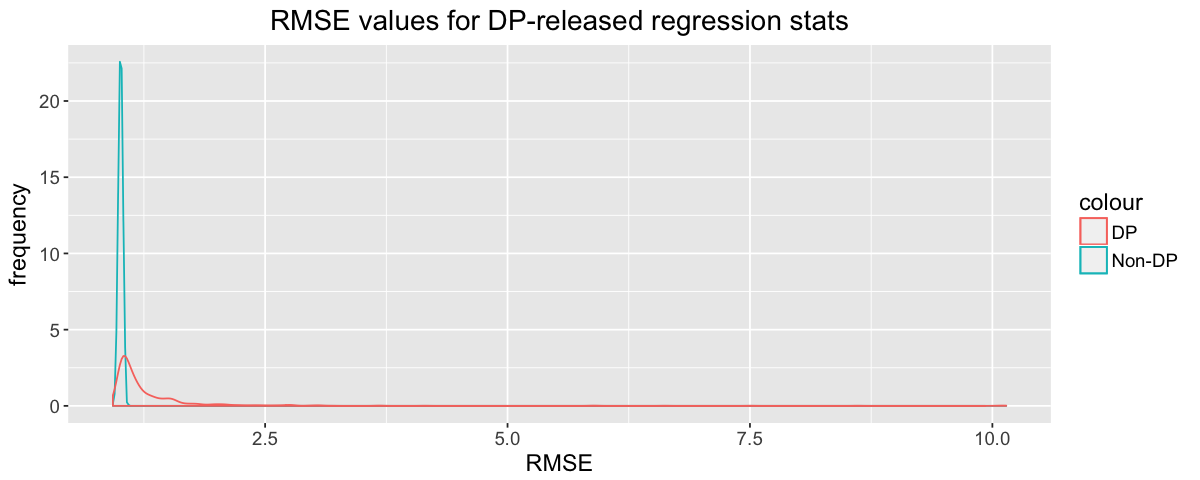

In [12]:
#### Plot results ####
library(ggplot2)
final_results <- as.data.frame(rmse_vals);
colnames(final_results) <- c("Simulation", "RMSE_DP", "RMSE_nonDP");
f_size = 16;

# Plot average RMSE of reconstruction against noise input #
#geom_density
p_rmse <- ggplot(data = final_results) + geom_density(aes(x=final_results$RMSE_nonDP, color='Non-DP')) + geom_density(aes(x=final_results$RMSE_DP, color='DP' ));
p_rmse <- p_rmse + labs(title="RMSE values for DP-released regression stats", x="RMSE", y="frequency") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));
options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions

p_rmse #show plot

**(c)**<br>